Common initialization

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Create dummy data

In [2]:
from sklearn.datasets import make_blobs

X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

### Gaussian Mixture Model

Read more: https://brilliant.org/wiki/gaussian-mixture-model/

Let's train a Gaussian mixture model on the previous dataset:

In [3]:
from sklearn.mixture import GaussianMixture

In [4]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

Let's look at the parameters that the EM algorithm estimated:

In [5]:
gm.weights_

array([0.39025715, 0.40007391, 0.20966893])

In [6]:
gm.means_

array([[ 0.05131611,  0.07521837],
       [-1.40763156,  1.42708225],
       [ 3.39893794,  1.05928897]])

In [7]:
gm.covariances_

array([[[ 0.68799922,  0.79606357],
        [ 0.79606357,  1.21236106]],

       [[ 0.63479409,  0.72970799],
        [ 0.72970799,  1.1610351 ]],

       [[ 1.14833585, -0.03256179],
        [-0.03256179,  0.95490931]]])

Did the algorithm actually converge?

In [8]:
gm.converged_

True

Yes, good. How many iterations did it take?

In [9]:
gm.n_iter_

4

You can now use the model to predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster. For this, just use `predict()` method or the `predict_proba()` method:

In [10]:
gm.predict(X)

array([0, 0, 1, ..., 2, 2, 2], dtype=int64)

In [11]:
gm.predict_proba(X)

array([[9.76741808e-01, 6.78581203e-07, 2.32575136e-02],
       [9.82832955e-01, 6.76173663e-04, 1.64908714e-02],
       [7.46494398e-05, 9.99923327e-01, 2.02398402e-06],
       ...,
       [4.26050456e-07, 2.15512941e-26, 9.99999574e-01],
       [5.04987704e-16, 1.48083217e-41, 1.00000000e+00],
       [2.24602826e-15, 8.11457779e-41, 1.00000000e+00]])

This is a generative model, so you can sample new instances from it (and get their labels):

In [12]:
X_new, y_new = gm.sample(6)
X_new

array([[-0.86944074, -0.32767626],
       [ 0.29836051,  0.28297011],
       [-2.8014927 , -0.09047309],
       [ 3.98203732,  1.49951491],
       [ 3.81677148,  0.53095244],
       [ 2.84104923, -0.73858639]])

In [13]:
y_new

array([0, 0, 1, 2, 2, 2])

Notice that they are sampled sequentially from each cluster.

You can also estimate the log of the _probability density function_ (PDF) at any location using the `score_samples()` method:

In [14]:
gm.score_samples(X)

array([-2.60768954, -3.57110232, -3.32987086, ..., -3.51347241,
       -4.39798588, -3.80746532])

Let's check that the PDF integrates to 1 over the whole space. We just take a large square around the clusters, and chop it into a grid of tiny squares, then we compute the approximate probability that the instances will be generated in each tiny square (by multiplying the PDF at one corner of the tiny square by the area of the square), and finally summing all these probabilities). The result is very close to 1:

In [15]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

0.9999999999215021

Now let's plot the resulting decision boundaries (dashed lines) and density contours:

In [16]:
from matplotlib.colors import LogNorm

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)
                
def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

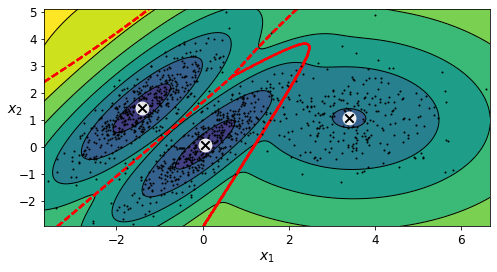

In [17]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

plt.show()

You can impose constraints on the covariance matrices that the algorithm looks for by setting the `covariance_type` hyperparameter:
* `"full"` (default): no constraint, all clusters can take on any ellipsoidal shape of any size.
* `"tied"`: all clusters must have the same shape, which can be any ellipsoid (i.e., they all share the same covariance matrix).
* `"spherical"`: all clusters must be spherical, but they can have different diameters (i.e., different variances).
* `"diag"`: clusters can take on any ellipsoidal shape of any size, but the ellipsoid's axes must be parallel to the axes (i.e., the covariance matrices must be diagonal).

In [18]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', n_components=3, n_init=10,
                random_state=42)

In [19]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)


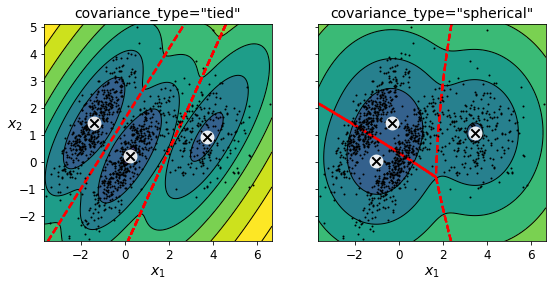

In [20]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)

plt.show()

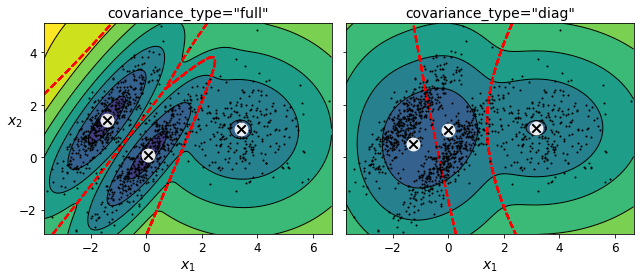

In [21]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

### Bayesian Gaussian Mixture Models

Rather than manually searching for the optimal number of clusters, it is possible to use instead the `BayesianGaussianMixture` class which is capable of giving weights equal (or close) to zero to unnecessary clusters. Just set the number of components to a value that you believe is greater than the optimal number of clusters, and the algorithm will eliminate the unnecessary clusters automatically.

In [22]:
from sklearn.mixture import BayesianGaussianMixture

In [23]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

The algorithm automatically detected that only 3 components are needed:

In [24]:
np.round(bgm.weights_, 2)

array([0.4 , 0.21, 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

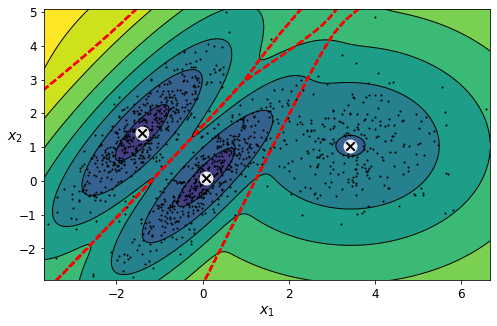

In [25]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

In [26]:
bgm_low = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=0.01, random_state=42)
bgm_high = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=10000, random_state=42)
nn = 73
bgm_low.fit(X[:nn])
bgm_high.fit(X[:nn])

BayesianGaussianMixture(max_iter=1000, n_components=10, random_state=42,
                        weight_concentration_prior=10000)

In [27]:
np.round(bgm_low.weights_, 2)

array([0.52, 0.48, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [28]:
np.round(bgm_high.weights_, 2)

array([0.01, 0.18, 0.27, 0.11, 0.01, 0.01, 0.01, 0.01, 0.37, 0.01])

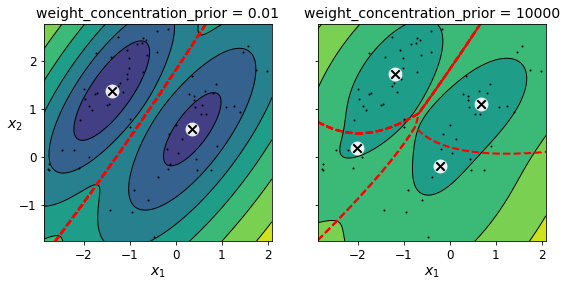

In [29]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
plot_gaussian_mixture(bgm_low, X[:nn])
plt.title("weight_concentration_prior = 0.01", fontsize=14)

plt.subplot(122)
plot_gaussian_mixture(bgm_high, X[:nn], show_ylabels=False)
plt.title("weight_concentration_prior = 10000", fontsize=14)

plt.show()